# Let's All Go To The Movies! 🎥

### Introduction:

I started this project because I'm insterested in recommender systems. I like the potential for customization beyond a cookie-cutter basics, and am intrigued by their organic evolution over time. Unlike some aspects of AI, I feel that they do more good than harm, ultimately by helping us sift through the increasing number of products and choices that bombard us. 

### The Problem:

Movie lovers are a varied bunch, some like blockbusters, while others prefer indie art-house flicks. Recommendation systems built using mass input may lack the ability to differentiate user populations and accordingly tailor their recommendations. Potential lost revenue and customer churn are possibilities if the consumer does not feel that the set of recommendations is valid for their tastes. 

### The Data:

I've decided to work with movies, because they're fun and everyone enjoys a good film. This project will be based on the MovieLens most recent small dataset, updated 10/2016. It's publicly available, and since I don't have a server farm, manageable enough to work with. The dataset contains a set of movie rankings provided by users. The dataset is a snapshot of movies ranked by users, and does not include additional attributes such as future movies purchased, which may be useful in evaluating the effectiveness of a recommender. The data also does not contain timestamps. Although genre attributes are included with the dataset, I have not incorporated these features for this analysis.  

### Objectives:

I had several objectives in undertaking this project. The first was to see if I could independently develop a recommender system. While that's all well and good, it's not very interesting. Thus, my secondary objective in this project was to incorporate population segmentation into the system in an effort to create more meaningful recommenations. 

The word 'meaningful' in my last sentence is where things get tricky. Admittedly, I don't have a way to quantifiably measure this. The dataset I'm using is a snapshot of ratings, and does not include other behaviors that might be used to measure it, such as future movies purchased. Therefore, I'm going to lean heavily on correlations. The correlations should tell me how similar the movies are, and hence should be a reasonable proxy for the strength of the recommendation. Stronger correlations should indicate better recommendations. I'll speak more about the specifics of this in my discussion of the evaluation framework below. 

#### Key Assumptions:
Popular movies will get the most ratings, while more obscure films will have fewer ratings. It is my assumption that the user population can be segmented into 3 unique sub-populations based on their ratings of popular films:

1. Blockbuster Fans: The majority of these users' rankings are comprised of the most popular movies. They like big Hollywood productions, and rarely watch and rate less well-known titles.
2. Indie Fans: The opposite of the Blockbusters, these users primarily prefer less popular films.
3. Crossover Fans: These users don't have a demonstrated preference and will watch either blockbusters or indie films.

I am also going to overlay a lens of quality when creating the segmentation. I wouldn't want a recommendations for bad movies, even if they're popular. Therefore, I'm going to score the movies by multiplying their number of ratings (popularity) by their average rating (quality). The popularity component will still be the largest factor in how movies are ranked, but I will now be able to temper this somewhat by combining it with a measurement of quality. 

#### Hypothesis: 
Segmenting the user population according movie ranking patterns results in improved recommendations that are better targeted to the user's taste. 

#### Null Hypothesis: 
User segmentation does not lead to an improvement in recommendations.

#### Hypothesis Evaluation:
The hypothesis will be evaluated by producing recommendations with and without segmentation. Average correlations for the reccomendations will be calculated for each segment under both condition, and the hypothesis will either be accepted or rejected based on the higher correlations. The Pearson correlations will be for the top three recommended movies, and their absolute values will be used. 


# Action! Let's explore some data.




In [1]:
#Starting off with familiar imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#I use the rcParams command because I want the bars in my bar charts to have edges
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True

In [2]:
#Reading in the data, and creating my working dataframe
m_df = pd.read_csv('movies.csv', sep=',', usecols=range(2))
r_df = pd.read_csv('ratings.csv', sep=',', usecols=range(3))

movies = pd.merge(r_df, m_df, on='movieId')

In [3]:
#Exploring the length of the dataframes
print('length of movies.csv = ' + str(len(m_df)))
print('length of ratings.csv = ' + str(len(r_df)))
print('length of movies dataframe = ' + str(len(movies)))

length of movies.csv = 9125
length of ratings.csv = 100004
length of movies dataframe = 100004


In [4]:
#EDA - getting the shape of the dataframe
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId     100004 non-null int64
movieId    100004 non-null int64
rating     100004 non-null float64
title      100004 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 3.8+ MB


In [5]:
#EDA - checking out the head and tail of the dataframe
movies.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [6]:
movies.tail()

,userId,movieId,rating,title
99999,664,64997,2.5,War of the Worlds (2005)
100000,664,72380,3.5,"Box, The (2009)"
100001,665,129,3.0,Pie in the Sky (1996)
100002,665,4736,1.0,Summer Catch (2001)
100003,668,6425,1.0,"6th Man, The (Sixth Man, The) (1997)"


In [7]:
#More EDA - Exploring the rankings distribution
movies['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

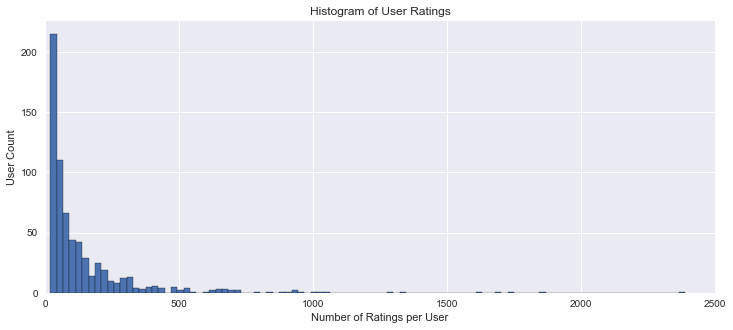

In [8]:
#Let's plot the number of ratings by user. Looks like most users rank just a few movies.
user_freq = movies.groupby('userId').size()

fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlim([0,2500])
plt.hist(user_freq, bins=100)
plt.xlabel('Number of Ratings per User')
plt.ylabel('User Count')
plt.title('Histogram of User Ratings')
plt.show()

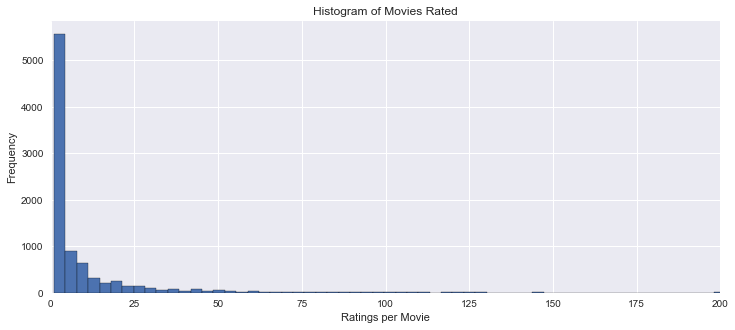

In [9]:
#Now let's take a look at the distribution of ratings per movie. A lot of movies receive
#a few ratings, while a handful get a lot of ratings
movie_freq = movies.groupby('movieId').size()

fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlim([0,200])
plt.hist(movie_freq, bins=100)
plt.xlabel('Ratings per Movie')
plt.ylabel('Frequency')
plt.title('Histogram of Movies Rated')
plt.show()

In [10]:
#What are the top rated movies? Let's take a look

grouped = movies.groupby('title')['rating'].agg(['size', 'mean']).reset_index()
grouped['score'] = grouped['size']*grouped['mean']
grouped = grouped.sort_values('score', ascending=False)


grouped.head(10)

,title,size,mean,score
7084,"Shawshank Redemption, The (1994)",311,4.487138,1395.5
2933,Forrest Gump (1994),341,4.054252,1382.5
6391,Pulp Fiction (1994),324,4.256173,1379.0
7166,"Silence of the Lambs, The (1991)",304,4.138158,1258.0
7488,Star Wars: Episode IV - A New Hope (1977),291,4.221649,1228.5
5102,"Matrix, The (1999)",259,4.183398,1083.5
6918,Schindler's List (1993),244,4.303279,1050.0
4307,Jurassic Park (1993),274,3.706204,1015.5
7489,Star Wars: Episode V - The Empire Strikes Back...,234,4.232906,990.5
8248,Toy Story (1995),247,3.872470,956.5


In [11]:
#Back to the EDA - let's compute our scores
movie_score = movies.groupby('movieId')['rating'].agg(['size', 'mean']).reset_index()
movie_score['score'] = movie_score['size']*movie_score['mean']
movie_score.head()

,movieId,size,mean,score
0,1,247,3.872470,956.5
1,2,107,3.401869,364.0
2,3,59,3.161017,186.5
3,4,13,2.384615,31.0
4,5,56,3.267857,183.0


In [12]:
#Intersting to see the distributions of the variables
movie_score.describe()

,movieId,size,mean,score
count,9066.000000,9066.000000,9066.000000,9066.000000
mean,30772.100044,11.030664,3.292054,39.088352
std,40418.420801,24.050800,0.881968,92.151453
min,1.000000,1.000000,0.500000,0.500000
25%,2829.750000,1.000000,2.843750,4.000000
50%,6248.000000,3.000000,3.500000,9.000000
75%,55827.500000,9.000000,3.966250,30.500000
max,163949.000000,341.000000,5.000000,1395.500000


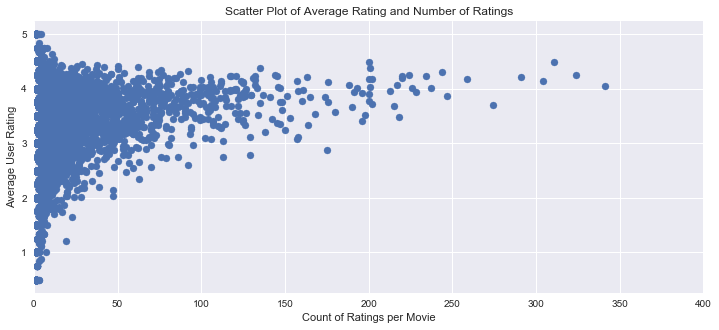

In [13]:
#Now let's visualize a plot of popularity vs. rating
fig, ax = plt.subplots(figsize=(12,5))
ax.set_xlim([0,400])
plt.scatter(movie_score['size'], movie_score['mean'])
plt.xlabel('Count of Ratings per Movie')
plt.ylabel('Average User Rating')
plt.title('Scatter Plot of Average Rating and Number of Ratings')
plt.show()

### More EDA - Time for Segmentation

In [14]:
#Extracting top rated movies, with a score of > 150 based on the plot above
top_rated = movie_score[movie_score['score']>150]
top_rated = top_rated.reset_index()
top_list = top_rated['movieId'].tolist()

In [15]:
#How many movies meet this criteria?
len(top_list)

566

In [16]:
#Looking up the movie ID in the top rated list
movies['top_rated'] = movies['movieId'].apply(lambda x: 1 if x in top_list else 0)
movies.head()

,userId,movieId,rating,title,top_rated
0,1,31,2.5,Dangerous Minds (1995),0
1,7,31,3.0,Dangerous Minds (1995),0
2,31,31,4.0,Dangerous Minds (1995),0
3,32,31,4.0,Dangerous Minds (1995),0
4,36,31,3.0,Dangerous Minds (1995),0


In [17]:
#Calculating each user's percentage of movies rated that are the top rated movies for segmentation
user_tot = pd.DataFrame(movies.groupby('userId')['top_rated'].size())
user_tot.columns=['total_rated']

user_top = pd.DataFrame(movies.groupby('userId')['top_rated'].sum())
user_top.columns=['top_rated']

user_stats = pd.merge(user_tot, user_top, left_index=True, right_index=True)
user_stats['pct_top'] = user_stats['top_rated']/user_stats['total_rated']
user_stats.head()

,total_rated,top_rated,pct_top
userId,,,
1,20,13,0.650000
2,76,60,0.789474
3,51,34,0.666667
4,204,118,0.578431
5,100,84,0.840000


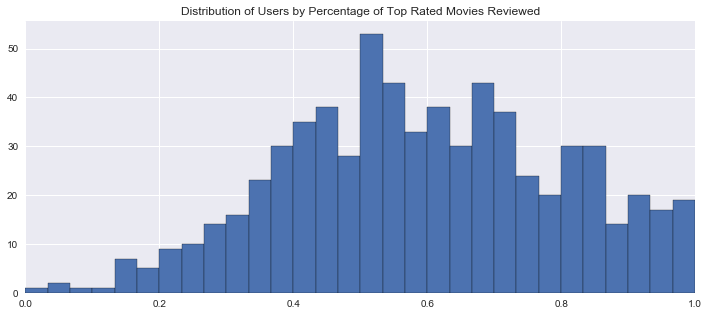

In [18]:
#Plotting the distribution of users according to the % of top rated movies reviewed
#Most users rate a mix of the top movies and lesser rated titles, as expected
fig, ax = plt.subplots(figsize=(12,5))
plt.hist(user_stats['pct_top'], bins=30)
plt.title('Distribution of Users by Percentage of Top Rated Movies Reviewed')
ax.set_xlim([0,1])
plt.show()

In [19]:
#Creating the segmentation based on % of popular movies reviewed
#Indie fans are group A, as they rate popular movies less than 30% of the time
#Blockbuster fans are group B, as they rate popular movies more than 70% of the time
#Crossover fans are group C

def segment(x):
    if x <= 0.4:
        return 'A'
    elif x >= 0.7:
        return 'B'
    else:
        return 'C'


user_stats['segment'] = user_stats['pct_top'].apply(segment)

user_stats = user_stats.reset_index()

users = user_stats[['userId', 'segment']]

In [20]:
#Let's look at the counts of users according to their segmentation
users['segment'].value_counts()

C    340
B    211
A    120
Name: segment, dtype: int64

### Moving on to building recommendations

In [21]:
#Merging the user details and segmentation with movie details to create recommendations
movies = pd.merge(movies, users, on='userId')
movies.head()

,userId,movieId,rating,title,top_rated,segment
0,1,31,2.5,Dangerous Minds (1995),0,C
1,1,1029,3.0,Dumbo (1941),1,C
2,1,1061,3.0,Sleepers (1996),0,C
3,1,1129,2.0,Escape from New York (1981),1,C
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),1,C


In [22]:
#Creating a pivot of all users and all movies
ratings_pivot = movies.pivot_table(index=['userId'], columns=['title'], values='rating')
ratings_pivot.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#Getting the top 3 highest rated movies for each user
movies = movies.sort_values(['userId', 'rating'], ascending=[True, False])
top3_movies = movies.groupby('userId').head(3)
top3_movies.head(6)

,userId,movieId,rating,title,top_rated,segment
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),1,C
12,1,1953,4.0,"French Connection, The (1971)",1,C
13,1,2105,4.0,Tron (1982),1,C
74845,2,17,5.0,Sense and Sensibility (1995),1,B
74846,2,39,5.0,Clueless (1995),1,B
74853,2,150,5.0,Apollo 13 (1995),1,B


In [24]:
top3_pivot = top3_movies.pivot_table(index=['userId'], columns=['title'], values='rating')
top3_pivot.head()

title,10 Things I Hate About You (1999),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),27 Dresses (2008),28 Days Later (2002),300 (2007),"Abyss, The (1989)",Addams Family Values (1993),"African Queen, The (1951)","Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972)",...,Who Framed Roger Rabbit? (1988),Wild Things (1998),Willow (1988),Willy Wonka & the Chocolate Factory (1971),Witness (1985),"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",You've Got Mail (1998),Young Frankenstein (1974),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#Data Wrangling - Creating a list of each user's top 3 rated movies, for future comparison
tot = []
for x in range(len(top3_pivot)):
    movielist = []
    for c in range(len(top3_pivot.columns)):
        if top3_pivot.iloc[x,c] > 0:
            movielist.append(top3_pivot.columns[c])
    tot.append(movielist)

In [26]:
tot_df = pd.DataFrame(tot)
tot_df.head()

,0,1,2
0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),"French Connection, The (1971)",Tron (1982)
1,Apollo 13 (1995),Clueless (1995),Sense and Sensibility (1995)
2,Forrest Gump (1994),"Princess Bride, The (1987)","Shawshank Redemption, The (1994)"
3,"French Connection, The (1971)",Pulp Fiction (1994),Time Bandits (1981)
4,Grease (1978),"Little Mermaid, The (1989)",Pretty Woman (1990)


In [27]:
#Data Wrangling - Add user IDs and segment info to the top 3 rated movies - for future comparison
segments = top3_movies[['userId', 'segment']]
segments = segments.drop_duplicates()
segments = segments.reset_index()
tot_df = pd.concat([tot_df, segments], axis=1)
tot_df = tot_df.drop('index', axis=1)

In [28]:
tot_df.head()

,0,1,2,userId,segment
0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),"French Connection, The (1971)",Tron (1982),1,C
1,Apollo 13 (1995),Clueless (1995),Sense and Sensibility (1995),2,B
2,Forrest Gump (1994),"Princess Bride, The (1987)","Shawshank Redemption, The (1994)",3,C
3,"French Connection, The (1971)",Pulp Fiction (1994),Time Bandits (1981),4,C
4,Grease (1978),"Little Mermaid, The (1989)",Pretty Woman (1990),5,B


### First Up: Segmentation Recommendations

In [29]:
movies_a = movies[movies['segment']=='A']
movies_b = movies[movies['segment']=='B']
movies_c = movies[movies['segment']=='C']

In [30]:
ratings_pivot_a = movies_a.pivot_table(index=['userId'], columns=['title'], values='rating')
ratings_pivot_b = movies_b.pivot_table(index=['userId'], columns=['title'], values='rating')
ratings_pivot_c = movies_c.pivot_table(index=['userId'], columns=['title'], values='rating')

ratings_pivot_b.head()

title,'Hellboy': The Seeds of Creation (2004),'Salem's Lot (2004),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...And Justice for All (1979),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),...,Zatoichi on the Road (Zatôichi kenka-tabi) (Zatôichi 5) (1963),Zelig (1983),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),Zorba the Greek (Alexis Zorbas) (1964),Zulu (1964),loudQUIETloud: A Film About the Pixies (2006),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Creating correlations, this takes a while to run
#Using different minimum periods to establish correlations. It's a rough guess, but could be optimized further
seg_a_corr = ratings_pivot_a.corr(method='pearson', min_periods=15)
seg_b_corr = ratings_pivot_b.corr(method='pearson', min_periods=15)
seg_c_corr = ratings_pivot_c.corr(method='pearson', min_periods=15)

In [32]:
#Create list of top 3 recommendations according to segment-based correlation scores
#This was a bit difficult, but the examples below are useful for understanding the process
recs = []
corrs = []
for x in range(len(tot_df)):
    recd = {}
    r = 0
    for c in range(len(tot_df.columns[0:3])):
        if tot_df.iloc[x,4]=='A':
            t = seg_a_corr[tot_df.iloc[x,c]].dropna().sort_values(ascending=False)[1:4]
        elif tot_df.iloc[x,4]=='B':
            t = seg_b_corr[tot_df.iloc[x,c]].dropna().sort_values(ascending=False)[1:4]
        else:
            t = seg_c_corr[tot_df.iloc[x,c]].dropna().sort_values(ascending=False)[1:4]
        recd.update(t)
        v = recd.values()
        v.sort(reverse=True)
        v = v[0:3]
        reclist = []
        for i in v:
            rec = recd.keys()[recd.values().index(i)]
            reclist.append(rec)
    for i in v:
        r += abs(i)
    recs.append(reclist)
    corrs.append(r/3)

In [33]:
#Data Wrangling - Turn recommendations into a dataframe
recs = pd.DataFrame(recs)
recs.head()

,0,1,2
0,Starship Troopers (1997),Star Trek: First Contact (1996),Fargo (1996)
1,Indiana Jones and the Last Crusade (1989),"Lord of the Rings: The Fellowship of the Ring,...",Pretty Woman (1990)
2,Gran Torino (2008),Glory (1989),"Jerk, The (1979)"
3,Rushmore (1998),A.I. Artificial Intelligence (2001),Witness (1985)
4,Titanic (1997),Clueless (1995),E.T. the Extra-Terrestrial (1982)


In [34]:
corr_seg = pd.DataFrame(corrs, columns=['seg_corr'])
corr_seg.head()

,seg_corr
0,0.622858
1,0.657619
2,0.776193
3,0.704789
4,0.695051


In [35]:
#The final step - Adding user ID and segment info to recommendations for comparison
recs_df = pd.concat([recs, segments], axis=1)
recs_df = recs_df.drop('index', axis=1)
recs_df.head()

,0,1,2,userId,segment
0,Starship Troopers (1997),Star Trek: First Contact (1996),Fargo (1996),1,C
1,Indiana Jones and the Last Crusade (1989),"Lord of the Rings: The Fellowship of the Ring,...",Pretty Woman (1990),2,B
2,Gran Torino (2008),Glory (1989),"Jerk, The (1979)",3,C
3,Rushmore (1998),A.I. Artificial Intelligence (2001),Witness (1985),4,C
4,Titanic (1997),Clueless (1995),E.T. the Extra-Terrestrial (1982),5,B


### Now let's build recommendations without segmentation

In [36]:
tot_corr = ratings_pivot.corr(method='pearson', min_periods=15)

In [37]:
tot_recs = []
tot_corrs = []
for x in range(len(tot_df)):
    recd = {}
    r = 0
    for c in range(len(tot_df.columns[0:3])):
        t = tot_corr[tot_df.iloc[x,c]].dropna().sort_values(ascending=False)[1:4]
        recd.update(t)
        v = recd.values()
        v.sort(reverse=True)
        v = v[0:3]
        reclist = []
        for i in v:
            rec = recd.keys()[recd.values().index(i)]
            reclist.append(rec)
    for i in v:
        r += abs(i)
    tot_recs.append(reclist)
    tot_corrs.append(r/3)

In [38]:
#Data Wrangling - Turn recommendations into a dataframe
trecs = pd.DataFrame(tot_recs)
trecs.head()

,0,1,2
0,Annie Hall (1977),"Gods Must Be Crazy, The (1980)",Get Shorty (1995)
1,Bambi (1942),Red Dragon (2002),Mean Girls (2004)
2,Dirty Rotten Scoundrels (1988),"Curious Case of Benjamin Button, The (2008)",Diner (1982)
3,"Gods Must Be Crazy, The (1980)",Kill Bill: Vol. 1 (2003),Goldfinger (1964)
4,Hackers (1995),Matchstick Men (2003),Harry Potter and the Goblet of Fire (2005)


In [39]:
#The final step - Adding user ID and segment info to recommendations for comparison
trecs_df = pd.concat([trecs, segments], axis=1)
trecs_df = trecs_df.drop('index', axis=1)
trecs_df.head()

,0,1,2,userId,segment
0,Annie Hall (1977),"Gods Must Be Crazy, The (1980)",Get Shorty (1995),1,C
1,Bambi (1942),Red Dragon (2002),Mean Girls (2004),2,B
2,Dirty Rotten Scoundrels (1988),"Curious Case of Benjamin Button, The (2008)",Diner (1982),3,C
3,"Gods Must Be Crazy, The (1980)",Kill Bill: Vol. 1 (2003),Goldfinger (1964),4,C
4,Hackers (1995),Matchstick Men (2003),Harry Potter and the Goblet of Fire (2005),5,B


In [40]:
corr_tot = pd.DataFrame(tot_corrs, columns=['tot_corr'])
corr_tot.head()

,tot_corr
0,0.828030
1,0.778982
2,0.836010
3,0.811582
4,0.827153


# Results: How do they compare?

In [41]:
compare_df = pd.concat([tot_df, corr_tot, corr_seg], axis=1)
compare_df.head()

,0,1,2,userId,segment,tot_corr,seg_corr
0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),"French Connection, The (1971)",Tron (1982),1,C,0.828030,0.622858
1,Apollo 13 (1995),Clueless (1995),Sense and Sensibility (1995),2,B,0.778982,0.657619
2,Forrest Gump (1994),"Princess Bride, The (1987)","Shawshank Redemption, The (1994)",3,C,0.836010,0.776193
3,"French Connection, The (1971)",Pulp Fiction (1994),Time Bandits (1981),4,C,0.811582,0.704789
4,Grease (1978),"Little Mermaid, The (1989)",Pretty Woman (1990),5,B,0.827153,0.695051


In [42]:
#The moment of truth
compare_df.groupby('segment')['tot_corr', 'seg_corr'].mean()

,tot_corr,seg_corr
segment,,
A,0.803251,0.668056
B,0.808654,0.703290
C,0.810099,0.765128


# Discussion:

Well, it turns out that I have to reject my hypothesis. Using segmentation, the correlations were not improved, simplicity wins again. There could be a variety of reasons for this, as I mentioned at the outset, the dataset was limited. Perhaps the results would be different with a more robust segmentation strategy. Additionally, my evaluation criteria is subjective, and again, with more robust data, a stronger criteria could have been developed based on user behavior. In any event, I'm not giving up on segmentation... Just wait for the sequel!

## Interested in the recommendations?

### Indie Segment

Let's compare the top rated movies by user vs. our recommendations for these users. 

In [43]:
#The user's top 3 rated movies
tot_df[tot_df['segment']=='A'].head(3)

,0,1,2,userId,segment
10,"Last of the Mohicans, The (1992)",Pulp Fiction (1994),"Usual Suspects, The (1995)",11,A
11,Army of Darkness (1993),"Blues Brothers, The (1980)",Harold and Maude (1971),12,A
14,Pulp Fiction (1994),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)",15,A


In [44]:
#The segmentation recommendations
recs_df[recs_df['segment']=='A'].head(3)

,0,1,2,userId,segment
10,Dog Day Afternoon (1975),Casablanca (1942),Almost Famous (2000),11,A
11,Forrest Gump (1994),Grease (1978),Austin Powers: International Man of Mystery (1...,12,A
14,Dog Day Afternoon (1975),Willy Wonka & the Chocolate Factory (1971),Beetlejuice (1988),15,A


In [45]:
#Recommendations without segmentation
trecs_df[trecs_df['segment']=='A'].head(3)

,0,1,2,userId,segment
10,Ghost in the Shell (Kôkaku kidôtai) (1995),Awakenings (1990),Young Frankenstein (1974),11,A
11,Evil Dead II (Dead by Dawn) (1987),"People vs. Larry Flynt, The (1996)","Jerk, The (1979)",12,A
14,Ghost in the Shell (Kôkaku kidôtai) (1995),Zodiac (2007),Peter Pan (1953),15,A


### Blockbuster Segment

In [46]:
#The user's top 3 rated movies
tot_df[tot_df['segment']=='B'].head(3)

,0,1,2,userId,segment
1,Apollo 13 (1995),Clueless (1995),Sense and Sensibility (1995),2,B
4,Grease (1978),"Little Mermaid, The (1989)",Pretty Woman (1990),5,B
5,Lawrence of Arabia (1962),"Lord of the Rings: The Return of the King, The...",Léon: The Professional (a.k.a. The Professiona...,6,B


In [47]:
#The segmentation recommendations
recs_df[recs_df['segment']=='B'].head(3)

,0,1,2,userId,segment
1,Indiana Jones and the Last Crusade (1989),"Lord of the Rings: The Fellowship of the Ring,...",Pretty Woman (1990),2,B
4,Titanic (1997),Clueless (1995),E.T. the Extra-Terrestrial (1982),5,B
5,Terminator 2: Judgment Day (1991),"Lord of the Rings: The Two Towers, The (2002)","Dark Knight, The (2008)",6,B


In [48]:
#Recommendations without segmentation
trecs_df[trecs_df['segment']=='B'].head(3)

,0,1,2,userId,segment
1,Bambi (1942),Red Dragon (2002),Mean Girls (2004),2,B
4,Hackers (1995),Matchstick Men (2003),Harry Potter and the Goblet of Fire (2005),5,B
5,Shine (1996),"Lord of the Rings: The Two Towers, The (2002)",Toy Story 2 (1999),6,B


### Crossover Segment

In [49]:
#The user's top 3 rated movies
tot_df[tot_df['segment']=='C'].head(3)

,0,1,2,userId,segment
0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),"French Connection, The (1971)",Tron (1982),1,C
2,Forrest Gump (1994),"Princess Bride, The (1987)","Shawshank Redemption, The (1994)",3,C
3,"French Connection, The (1971)",Pulp Fiction (1994),Time Bandits (1981),4,C


In [50]:
#The segmentation recommendations
recs_df[recs_df['segment']=='C'].head(3)

,0,1,2,userId,segment
0,Starship Troopers (1997),Star Trek: First Contact (1996),Fargo (1996),1,C
2,Gran Torino (2008),Glory (1989),"Jerk, The (1979)",3,C
3,Rushmore (1998),A.I. Artificial Intelligence (2001),Witness (1985),4,C


In [51]:
#Recommendations without segmentation
trecs_df[trecs_df['segment']=='C'].head(3)

,0,1,2,userId,segment
0,Annie Hall (1977),"Gods Must Be Crazy, The (1980)",Get Shorty (1995),1,C
2,Dirty Rotten Scoundrels (1988),"Curious Case of Benjamin Button, The (2008)",Diner (1982),3,C
3,"Gods Must Be Crazy, The (1980)",Kill Bill: Vol. 1 (2003),Goldfinger (1964),4,C
